# Prediction of the number of migrations between two districts per year (Linear Regression)

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
f_vector = pd.read_csv("../feature_extraction/data/feature_vector_complete.csv")

In [94]:
f_vector["label_0"] = f_vector["label_0"].astype(int)
f_vector["label_1"] = f_vector["label_1"].astype(int)
f_vector["label_2"] = f_vector["label_2"].astype(int)

### Scale continuous variables

In [4]:
features_to_scale_degree = ['dist_size_or','dist_size_de','net_income_or', 'rev_1000_inh_or', 
                            'var_review_or', 'unemployed_or','eldery_perc_or', 'd_inner_n_or', 
                            'd_outer_n_or', 'var_n_biz','net_income_de', 'rev_1000_inh_de', 
                            'var_review_de', 'unemployed_de','eldery_perc_de', 'd_inner_n_de', 
                            'd_outer_n_de', "var_sale_m2_or","var_rent_m2_or","var_sale_m2_de",
                            "var_rent_m2_de", "n_tran_rs_or","n_tran_new_rs_or","n_tran_rs_de","n_tran_new_rs_de",
                            "mortage_executions"]#,'label_0', 'label_1', 'label_2']

features_to_scale_wo_degree = ['dist_size_or','dist_size_de','net_income_or', 'rev_1000_inh_or', 
                               'var_review_or', 'unemployed_or','eldery_perc_or','var_n_biz','net_income_de', 
                               'rev_1000_inh_de','var_review_de', 'unemployed_de','eldery_perc_de', 
                               "var_sale_m2_or","var_rent_m2_or","var_sale_m2_de","var_rent_m2_de",
                               "n_tran_rs_or","n_tran_new_rs_or","n_tran_rs_de","n_tran_new_rs_de",
                               "mortage_executions"]#,'label_0', 'label_1', 'label_2']

In [5]:
for feature in features_to_scale_degree:
    scaler = StandardScaler()
    f_vector[feature] = scaler.fit_transform(f_vector[feature])

### Split train and test values with balanced migration values

In [6]:
# Split dataset into info, x and y
info_cols = ["origin","destination","year","migrations"]
info = f_vector.loc[:,(info_cols)]
X_degree = f_vector.loc[:,(features_to_scale_degree)]
X_wo_degree = f_vector.loc[:,(features_to_scale_wo_degree)]
y = f_vector.loc[:,"migrations"]

In [7]:
# Assign labels (quartile) to target in order to split balanced train/test datasets
labels = pd.qcut(f_vector["migrations"], 5, labels=["q1","q2","q3","q4","q5"]).tolist()

In [8]:
# Split train/test datasets
X_train_degree, X_test_degree, y_train, y_test = train_test_split(X_degree, y, train_size=0.8, random_state=32, 
                                                                  stratify=labels)
X_train_wo_degree, X_test_wo_degree, y_train, y_test = train_test_split(X_wo_degree, y, train_size=0.8, random_state=32, 
                                                                  stratify=labels)

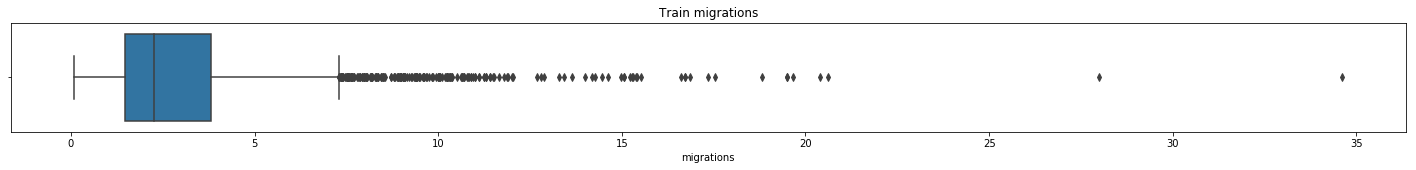

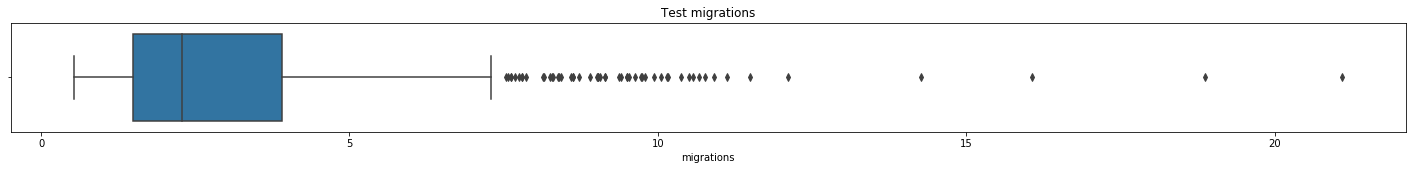

In [9]:
# Check if both samples have a similar distribution
_=plt.figure(figsize=(25, 2))
_=plt.title("Train migrations")
_=sns.boxplot(y_train)
_=plt.figure(figsize=(25, 2))
_=plt.title("Test migrations")
_=sns.boxplot(y_test)

## Model considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [10]:
# Train linear regression and predict migrations
lreg = LinearRegression()
lreg.fit(X_train_degree, y_train)
y_pred = lreg.predict(X_test_degree)
y_pred = np.array([x if x > 0 else 0 for x in y_pred])

In [11]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train_degree, y_train)
y_pred = regr.predict(X_test_degree)
y_pred = np.array([x if x > 0 else 0 for x in y_pred])

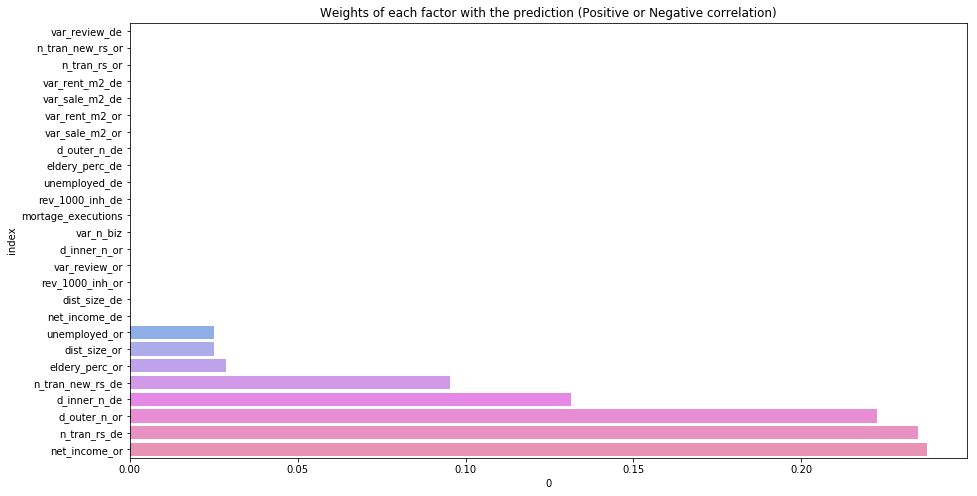

In [12]:
# Evaluate impact of each feature in the prediction during the optimization of the linear regression
factors = pd.DataFrame.from_dict(dict(zip(features_to_scale_degree,regr.feature_importances_)),
                                 orient='index').reset_index()
factors = factors.sort_values(by=0)
_=plt.figure(figsize=(15, 8))
_=plt.title("Weights of each factor with the prediction (Positive or Negative correlation)")
_=sns.barplot(y="index",x=0, data=factors)

The trend on migrations from the previous years have the highest impact what means that the migrations are not due to a punctual event but it is more a general long term trend.

The next featues with higher weight are the net income level and unemployment rates of the destination and the percentage of inhabitants with more than 65 years.

### Evaluate performance of the model

In [13]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test, y_pred)))

The RMSE in the test data set is: 2.41
 The r2 score in the test data set is: 0.04


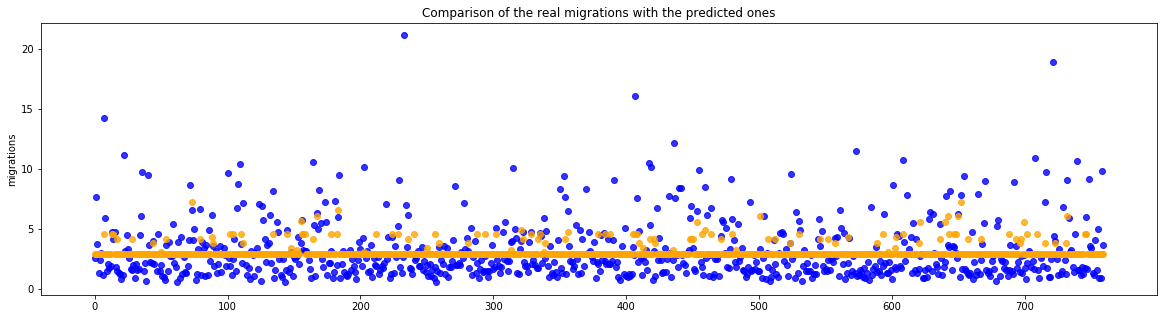

In [14]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test)), y=y_test, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

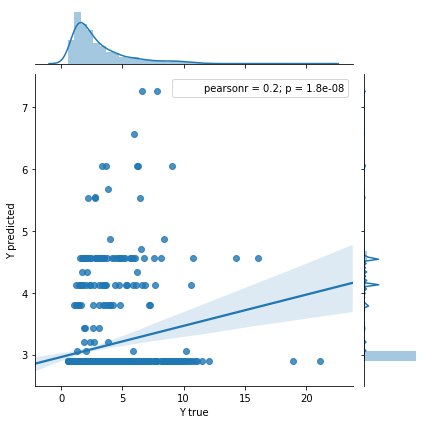

In [15]:
_=sns.jointplot(x=y_test, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

## Model without considering as feature inner/outer degree from previous year

### Train Linear Regression & Identify features with higher impact

In [16]:
# Train linear regression and predict migrations
lreg = LinearRegression()
lreg.fit(X_train_wo_degree, y_train)
y_pred = lreg.predict(X_test_wo_degree)
y_pred = np.array([x if x > 0 else 0 for x in y_pred])

In [17]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train_wo_degree, y_train)
y_pred = regr.predict(X_test_wo_degree)
y_pred = np.array([x if x > 0 else 0 for x in y_pred])

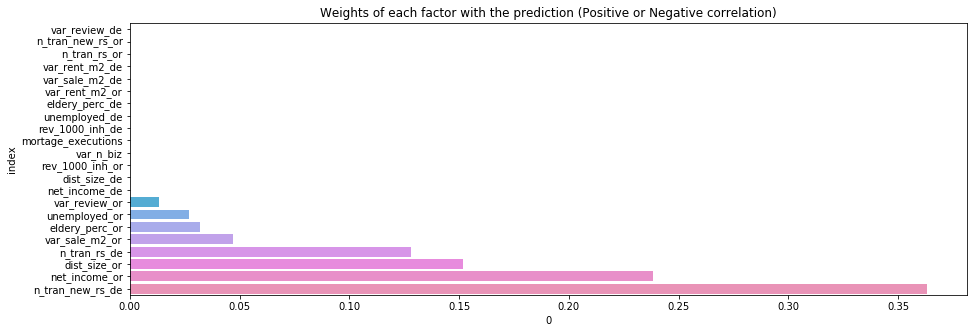

In [18]:
# Evaluate impact of each feature in the prediction during the optimization of the linear regression
factors = pd.DataFrame.from_dict(dict(zip(features_to_scale_wo_degree,regr.feature_importances_)),orient='index').reset_index()
factors = factors.sort_values(by=0)
_=plt.figure(figsize=(15, 5))
_=plt.title("Weights of each factor with the prediction (Positive or Negative correlation)")
_=sns.barplot(y="index",x=0, data=factors)

We see that the level of unemployment in the origin district is having a big impact on the prediction of migrations. 

Additionally, the level of net income and the percentage of inhabitants with more than 65 years as well.

Finally, neighbourhoods with higher number of inhabitants seem to be the ones between which the migrations happen.

### Evaluate performance of the model

In [19]:
print("The RMSE in the test data set is: {:0.2f}\n".format(math.sqrt(mean_squared_error(y_test, y_pred))), 
      "The r2 score in the test data set is: {:0.2f}".format(r2_score(y_test, y_pred)))

The RMSE in the test data set is: 2.40
 The r2 score in the test data set is: 0.05


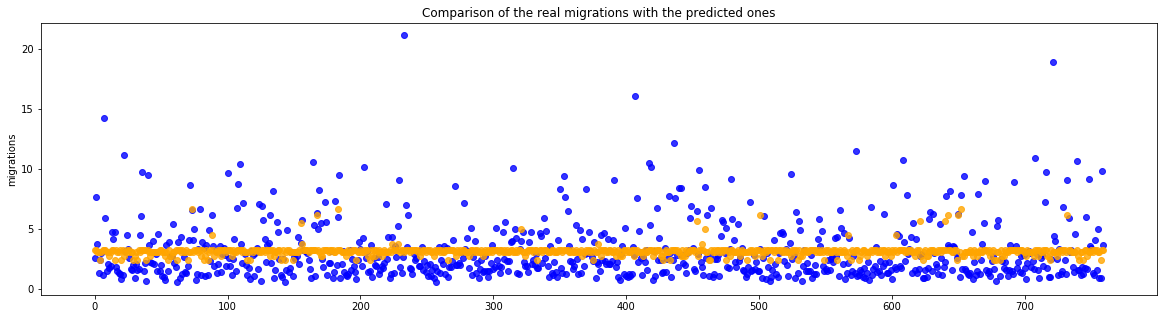

In [20]:
_=plt.figure(figsize=(20, 5))
_=plt.title("Comparison of the real migrations with the predicted ones")
_=sns.regplot(x=np.arange(len(y_test)), y=y_test, fit_reg=False, color="blue")
_=sns.regplot(x=np.arange(len(y_pred)), y=y_pred, fit_reg=False, color="orange")

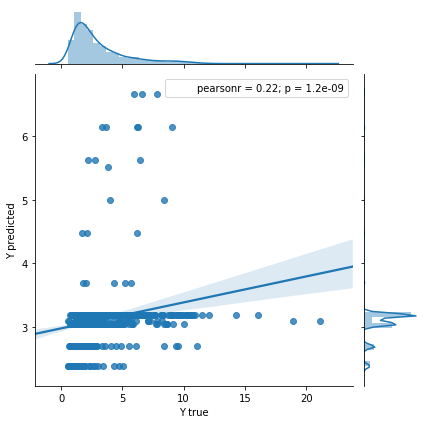

In [21]:
_=sns.jointplot(x=y_test, y=y_pred, kind="reg")
_=plt.xlabel("Y true")
_=plt.ylabel("Y predicted")

The pearson coefficient and the RMSE is practically the same considering the inner/outer degrees from previous year migrations per district or not.

Therefore, we can conclude that the migration effect is a long term trend and not dependent on special events (at least those migrations that consider less than 1000 inhabitants.